# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [46]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

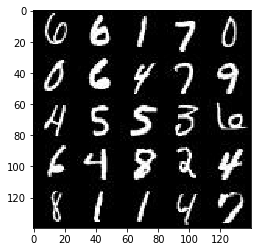

In [47]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

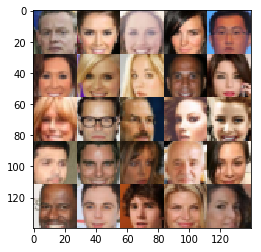

In [48]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [49]:
mnist_images[0].min()

20.0

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [50]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [51]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return input_real_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [62]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    training = True
    alpha=0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
    
        c1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')  # output shape = (None, 14, 14, 64)
        ##c1 = tf.layers.batch_normalization(c1, training=training)
        c1 = tf.maximum(c1, c1*alpha)

        c2 = tf.layers.conv2d(c1, 128, 5, strides=2, padding='same') # output shape = (None, 7, 7, 128)
        #c2 = tf.layers.batch_normalization(c2, training=training)
        c2 = tf.maximum(c2, c2*alpha)

        c3 = tf.layers.conv2d(c2, 256, 5, strides=2, padding='same') # output shape = (None, 4, 4, 256)
        #c3 = tf.layers.batch_normalization(c3, training=training)
        c3 = tf.maximum(c3, c3*alpha)

        f1 = tf.reshape(c3, [-1, 4*4*256])
        f1 = tf.layers.dropout(f1, rate=0.2)
        f1 = tf.layers.dense(f1, 1024) 
        f1 = tf.maximum(f1, f1*alpha)
        
        f2 = tf.layers.dropout(f1, rate=0.5)
        f2 = tf.layers.dense(f2, 1)

        logits = f2

        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [53]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.01

        d1 = tf.layers.dense(z, 7 * 7 * 256)
        d1 = tf.reshape(d1, [-1, 7, 7, 256])  # output shape=(None, 2, 2, 512)
        d1 = tf.layers.batch_normalization(d1, training=is_train)
        d1 = tf.maximum(d1, d1*alpha)

        c1 = tf.layers.conv2d_transpose(d1, 128, 5, strides=2, padding='same') # output shape = (None, 7, 7, 256)
        c1 = tf.layers.batch_normalization(c1, training=is_train)
        c1 = tf.maximum(c1, c1*alpha)
        
        c2 = tf.layers.conv2d_transpose(c1, 64, 5, strides=2, padding='same') # output shape = (None, 14, 14, 128)
        c2 = tf.layers.batch_normalization(c2, training=is_train)
        c2 = tf.maximum(c2, c2*alpha)
        
        c3 = tf.layers.conv2d_transpose(c2, out_channel_dim, 5, strides=1, padding='same')  # output shape = (None, 28, 28, 64)

        output = tf.tanh(c3)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [54]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = np.random.uniform(0.7, 0.9)
    
    img_gen = generator(input_z, out_channel_dim, is_train=True)
    _, logits_fake = discriminator(img_gen, reuse=False)
    
    _, logits_real = discriminator(input_real, reuse=True)
    
    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(
                                    labels=tf.zeros_like(logits_fake), 
                                    logits=logits_fake
                        )
                    )
    
    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(
                            labels=tf.ones_like(logits_real),
                            logits=(logits_real*smooth)
                        )
                    )
    
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        labels=tf.ones_like(logits_fake),
                        logits=logits_fake
                    )
                )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [59]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    d_beta_ratio = 0.3
    d_lr_ratio = 0.8
    
    d_vars = [var for var in tf.trainable_variables() if 'discriminator' in var.name]
    g_vars = [var for var in tf.trainable_variables() if 'generator' in var.name]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=(learning_rate*d_lr_ratio), beta1=(beta1*d_beta_ratio)).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_period = 20 # print result every 'print_period' every batch
    show_period = 100 # show image every 'show_period' epochs
    n_samples = 25
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    out_channel_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        summary = tf.summary.FileWriter('./summary/', sess.graph)
        
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step_i = 0
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                batch_z = np.random.uniform(-1, 1, size=(batch_images.shape[0], z_dim))
                _ = sess.run(fetches=d_train_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                _ = sess.run(fetches=g_train_opt,
                            feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
             
                if step_i % print_period == (print_period-1):
                    val_d_loss, val_g_loss = sess.run( fetches=[d_loss, g_loss], 
                                                        feed_dict={input_real: batch_images, 
                                                                input_z: batch_z, 
                                                                lr: learning_rate})
                
                    print('epoch {}, steps {}, d_loss={}, g_loss={}'.format(epoch_i, step_i, val_d_loss, val_g_loss))
            
                
                if (step_i % show_period) == (show_period - 1):
                    #print('epoch {}, d_loss={}, g_loss={}'.format(epoch_i, val_d_loss, val_g_loss))
                    show_generator_output(sess, n_samples, input_z, out_channel_dim, data_image_mode)
                    
                step_i += 1
                
        saver.save(sess, './model/face_generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch 0, steps 19, d_loss=4.713845729827881, g_loss=24.537551879882812
epoch 0, steps 39, d_loss=0.02543790079653263, g_loss=4.918619632720947
epoch 0, steps 59, d_loss=0.10314643383026123, g_loss=6.8383893966674805
epoch 0, steps 79, d_loss=2.39977765083313, g_loss=0.35504117608070374
epoch 0, steps 99, d_loss=0.40294814109802246, g_loss=2.8969759941101074


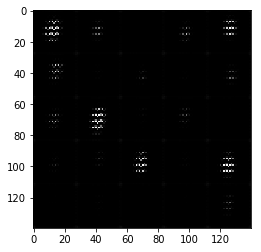

epoch 0, steps 119, d_loss=0.3172999620437622, g_loss=2.6565163135528564
epoch 0, steps 139, d_loss=0.4637652635574341, g_loss=2.3027195930480957
epoch 0, steps 159, d_loss=0.03741132467985153, g_loss=4.187731742858887
epoch 0, steps 179, d_loss=0.00619488675147295, g_loss=5.9215240478515625
epoch 0, steps 199, d_loss=0.014714865013957024, g_loss=5.419957160949707


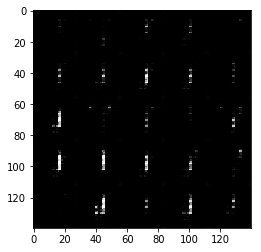

epoch 0, steps 219, d_loss=0.9306464791297913, g_loss=2.1423709392547607
epoch 0, steps 239, d_loss=0.6014960408210754, g_loss=1.8384597301483154
epoch 0, steps 259, d_loss=0.1065807193517685, g_loss=3.577514410018921
epoch 0, steps 279, d_loss=0.02243301086127758, g_loss=4.645951271057129
epoch 0, steps 299, d_loss=0.1800495684146881, g_loss=2.82362699508667


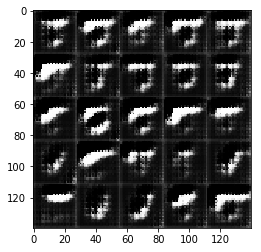

epoch 0, steps 319, d_loss=0.175227552652359, g_loss=2.651141405105591
epoch 0, steps 339, d_loss=0.9012233018875122, g_loss=1.3177143335342407
epoch 0, steps 359, d_loss=0.75581294298172, g_loss=1.7323918342590332
epoch 0, steps 379, d_loss=1.8039891719818115, g_loss=0.4181014597415924
epoch 0, steps 399, d_loss=2.43206787109375, g_loss=0.2045748233795166


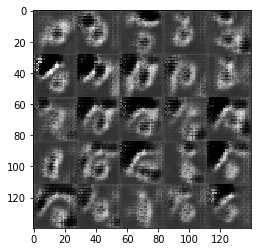

epoch 0, steps 419, d_loss=0.9863972067832947, g_loss=1.1671656370162964
epoch 0, steps 439, d_loss=0.6993093490600586, g_loss=2.5112433433532715
epoch 0, steps 459, d_loss=0.6532843112945557, g_loss=1.499698519706726
epoch 0, steps 479, d_loss=0.8026611804962158, g_loss=2.0199334621429443
epoch 0, steps 499, d_loss=0.5427483320236206, g_loss=2.5147314071655273


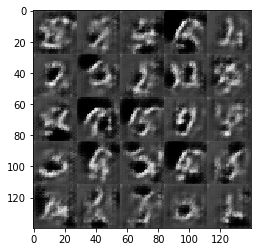

epoch 0, steps 519, d_loss=0.9606062173843384, g_loss=1.2942732572555542
epoch 0, steps 539, d_loss=0.44148439168930054, g_loss=2.63991117477417
epoch 0, steps 559, d_loss=0.6614605784416199, g_loss=2.4987566471099854
epoch 0, steps 579, d_loss=0.4457991123199463, g_loss=2.4752631187438965
epoch 0, steps 599, d_loss=0.6827943921089172, g_loss=3.1912572383880615


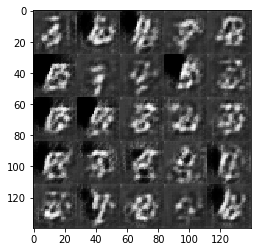

epoch 0, steps 619, d_loss=1.9204295873641968, g_loss=0.8926862478256226
epoch 0, steps 639, d_loss=0.5692723989486694, g_loss=2.1367650032043457
epoch 0, steps 659, d_loss=1.4520307779312134, g_loss=1.0038936138153076
epoch 0, steps 679, d_loss=0.3222735524177551, g_loss=2.607147693634033
epoch 0, steps 699, d_loss=1.1811494827270508, g_loss=1.3524192571640015


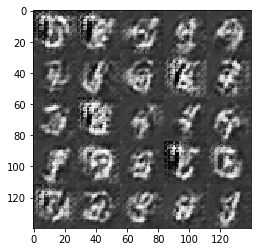

epoch 0, steps 719, d_loss=0.6869549751281738, g_loss=1.8201491832733154
epoch 0, steps 739, d_loss=0.5288026332855225, g_loss=2.672163724899292
epoch 0, steps 759, d_loss=0.34797441959381104, g_loss=3.5893144607543945
epoch 0, steps 779, d_loss=0.787903368473053, g_loss=3.7883949279785156
epoch 0, steps 799, d_loss=0.8518726229667664, g_loss=1.5754024982452393


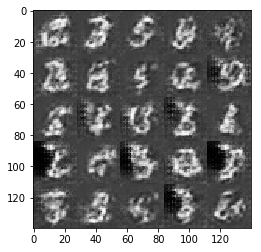

epoch 0, steps 819, d_loss=1.4999167919158936, g_loss=4.085916996002197
epoch 0, steps 839, d_loss=0.6677741408348083, g_loss=1.9790318012237549
epoch 0, steps 859, d_loss=0.305653840303421, g_loss=2.7808632850646973
epoch 0, steps 879, d_loss=0.5784938335418701, g_loss=2.7277493476867676
epoch 0, steps 899, d_loss=0.7771533727645874, g_loss=3.9730641841888428


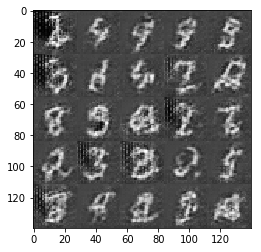

epoch 0, steps 919, d_loss=0.7884987592697144, g_loss=1.3410663604736328
epoch 0, steps 939, d_loss=0.9937491416931152, g_loss=3.4933042526245117
epoch 0, steps 959, d_loss=0.4972922205924988, g_loss=2.072329521179199
epoch 0, steps 979, d_loss=0.8508745431900024, g_loss=1.6381468772888184
epoch 0, steps 999, d_loss=1.2007863521575928, g_loss=0.6629984378814697


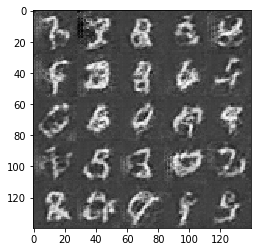

epoch 0, steps 1019, d_loss=0.430511474609375, g_loss=2.8320329189300537
epoch 0, steps 1039, d_loss=1.353015422821045, g_loss=1.0783462524414062
epoch 0, steps 1059, d_loss=0.9766120910644531, g_loss=0.9346277117729187
epoch 0, steps 1079, d_loss=1.520267128944397, g_loss=0.7030882835388184
epoch 0, steps 1099, d_loss=0.6099510192871094, g_loss=1.7592753171920776


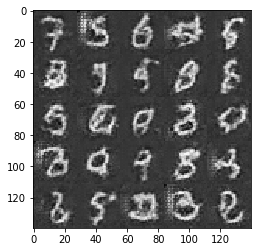

epoch 0, steps 1119, d_loss=0.4450148344039917, g_loss=2.131121873855591
epoch 0, steps 1139, d_loss=1.3122584819793701, g_loss=4.038995742797852
epoch 0, steps 1159, d_loss=1.371304988861084, g_loss=0.9770612120628357
epoch 0, steps 1179, d_loss=1.8268070220947266, g_loss=0.33296850323677063
epoch 0, steps 1199, d_loss=0.8630786538124084, g_loss=1.8766590356826782


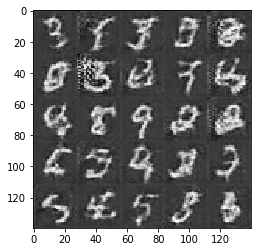

epoch 0, steps 1219, d_loss=2.5353190898895264, g_loss=5.511650085449219
epoch 0, steps 1239, d_loss=0.607345700263977, g_loss=1.2673404216766357
epoch 0, steps 1259, d_loss=1.52499520778656, g_loss=0.5512869358062744
epoch 0, steps 1279, d_loss=1.3653953075408936, g_loss=4.017271995544434
epoch 0, steps 1299, d_loss=0.6942922472953796, g_loss=1.854888916015625


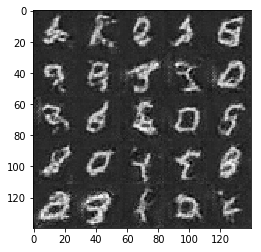

epoch 0, steps 1319, d_loss=0.43954169750213623, g_loss=2.0623841285705566
epoch 0, steps 1339, d_loss=1.035783052444458, g_loss=1.009143590927124
epoch 0, steps 1359, d_loss=0.7682508230209351, g_loss=3.22670841217041
epoch 0, steps 1379, d_loss=0.8347311615943909, g_loss=3.894021511077881
epoch 0, steps 1399, d_loss=2.2811105251312256, g_loss=0.26894161105155945


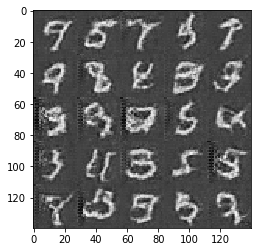

epoch 0, steps 1419, d_loss=0.6132729053497314, g_loss=2.541057586669922
epoch 0, steps 1439, d_loss=0.4614623188972473, g_loss=1.4655717611312866
epoch 0, steps 1459, d_loss=1.0154097080230713, g_loss=1.1219825744628906
epoch 0, steps 1479, d_loss=0.5649780035018921, g_loss=2.7223451137542725
epoch 0, steps 1499, d_loss=0.49092230200767517, g_loss=3.1956729888916016


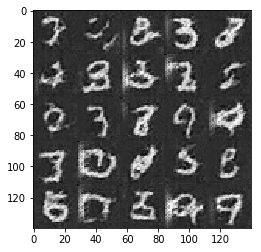

epoch 0, steps 1519, d_loss=0.46102505922317505, g_loss=1.502970814704895
epoch 0, steps 1539, d_loss=1.0320720672607422, g_loss=0.7573919296264648
epoch 0, steps 1559, d_loss=1.6301530599594116, g_loss=0.8591663241386414
epoch 0, steps 1579, d_loss=1.0078976154327393, g_loss=1.2789570093154907
epoch 0, steps 1599, d_loss=0.491017609834671, g_loss=2.399339199066162


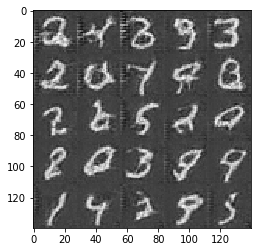

epoch 0, steps 1619, d_loss=0.6021320819854736, g_loss=1.5818854570388794
epoch 0, steps 1639, d_loss=0.7056345343589783, g_loss=3.1955554485321045
epoch 0, steps 1659, d_loss=0.9880618453025818, g_loss=1.0124317407608032
epoch 0, steps 1679, d_loss=0.4913787245750427, g_loss=2.5024235248565674
epoch 0, steps 1699, d_loss=0.7958469986915588, g_loss=3.9986138343811035


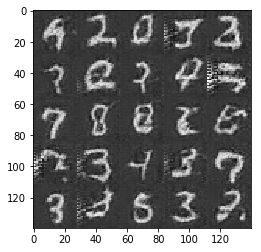

epoch 0, steps 1719, d_loss=1.5030388832092285, g_loss=0.7869685888290405
epoch 0, steps 1739, d_loss=0.38197097182273865, g_loss=3.4700441360473633
epoch 0, steps 1759, d_loss=0.5890620946884155, g_loss=3.7483367919921875
epoch 0, steps 1779, d_loss=0.7485978007316589, g_loss=1.4905674457550049
epoch 0, steps 1799, d_loss=0.7458508014678955, g_loss=1.4031957387924194


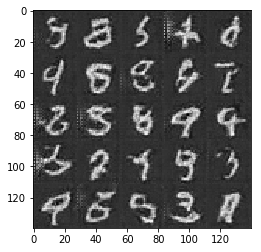

epoch 0, steps 1819, d_loss=0.23067505657672882, g_loss=2.3955602645874023
epoch 0, steps 1839, d_loss=1.6208291053771973, g_loss=0.9562753438949585
epoch 0, steps 1859, d_loss=0.6860593557357788, g_loss=1.3159873485565186
epoch 1, steps 19, d_loss=0.4570425748825073, g_loss=1.546962857246399
epoch 1, steps 39, d_loss=0.5882185101509094, g_loss=1.5219755172729492
epoch 1, steps 59, d_loss=0.8826496005058289, g_loss=1.1677768230438232
epoch 1, steps 79, d_loss=0.4761883020401001, g_loss=2.1722543239593506
epoch 1, steps 99, d_loss=0.9217969179153442, g_loss=0.8948957920074463


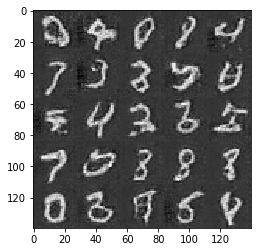

epoch 1, steps 119, d_loss=0.5545589327812195, g_loss=1.5840694904327393
epoch 1, steps 139, d_loss=0.5876476764678955, g_loss=1.4782037734985352
epoch 1, steps 159, d_loss=1.2806116342544556, g_loss=1.7817355394363403
epoch 1, steps 179, d_loss=0.5899655222892761, g_loss=1.6034797430038452
epoch 1, steps 199, d_loss=1.185789704322815, g_loss=4.81538724899292


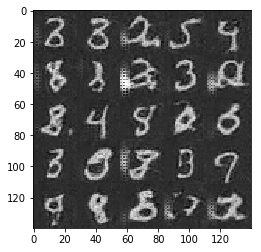

epoch 1, steps 219, d_loss=0.44113773107528687, g_loss=1.8774713277816772
epoch 1, steps 239, d_loss=2.043872117996216, g_loss=4.900920391082764
epoch 1, steps 259, d_loss=0.35849085450172424, g_loss=2.026257276535034
epoch 1, steps 279, d_loss=0.9992191791534424, g_loss=0.9829730987548828
epoch 1, steps 299, d_loss=1.0563971996307373, g_loss=0.9349209070205688


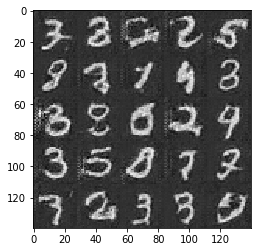

epoch 1, steps 319, d_loss=0.4873545467853546, g_loss=2.473426342010498
epoch 1, steps 339, d_loss=0.6293346881866455, g_loss=1.6871685981750488
epoch 1, steps 359, d_loss=0.906314492225647, g_loss=3.377692222595215
epoch 1, steps 379, d_loss=0.7316529154777527, g_loss=1.7294845581054688
epoch 1, steps 399, d_loss=0.3445947766304016, g_loss=1.774760365486145


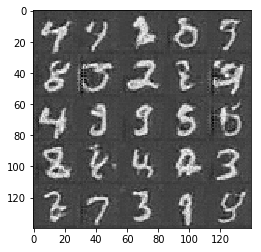

epoch 1, steps 419, d_loss=0.44317740201950073, g_loss=2.314297914505005
epoch 1, steps 439, d_loss=0.5625220537185669, g_loss=1.4404804706573486
epoch 1, steps 459, d_loss=1.082340121269226, g_loss=3.79715633392334
epoch 1, steps 479, d_loss=0.8175504207611084, g_loss=3.0998589992523193
epoch 1, steps 499, d_loss=0.6550718545913696, g_loss=1.819085955619812


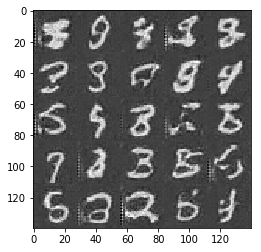

epoch 1, steps 519, d_loss=0.6615110039710999, g_loss=1.5531041622161865
epoch 1, steps 539, d_loss=0.6660158038139343, g_loss=1.582836627960205
epoch 1, steps 559, d_loss=0.3969024419784546, g_loss=1.84037184715271
epoch 1, steps 579, d_loss=0.27074432373046875, g_loss=2.667625904083252
epoch 1, steps 599, d_loss=0.35527339577674866, g_loss=2.584441900253296


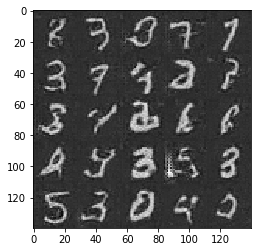

epoch 1, steps 619, d_loss=0.4346943497657776, g_loss=3.0458717346191406
epoch 1, steps 639, d_loss=0.559418797492981, g_loss=1.4674617052078247
epoch 1, steps 659, d_loss=0.721295177936554, g_loss=2.0048828125
epoch 1, steps 679, d_loss=0.5958123803138733, g_loss=1.2066645622253418
epoch 1, steps 699, d_loss=1.8890239000320435, g_loss=5.1790289878845215


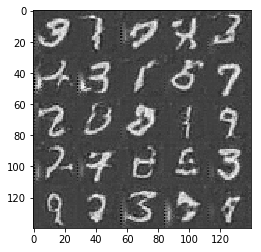

epoch 1, steps 719, d_loss=0.38623127341270447, g_loss=2.2882184982299805
epoch 1, steps 739, d_loss=0.39574119448661804, g_loss=2.850144624710083
epoch 1, steps 759, d_loss=0.10585133731365204, g_loss=3.2166786193847656
epoch 1, steps 779, d_loss=0.4134911298751831, g_loss=1.6695075035095215
epoch 1, steps 799, d_loss=1.6204134225845337, g_loss=3.961860418319702


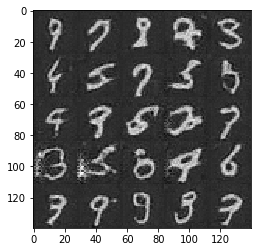

epoch 1, steps 819, d_loss=0.47492605447769165, g_loss=3.2646474838256836
epoch 1, steps 839, d_loss=1.0072247982025146, g_loss=1.2269340753555298
epoch 1, steps 859, d_loss=0.2702430784702301, g_loss=1.97922945022583
epoch 1, steps 879, d_loss=0.5867995619773865, g_loss=1.5846081972122192
epoch 1, steps 899, d_loss=0.44769370555877686, g_loss=2.057621955871582


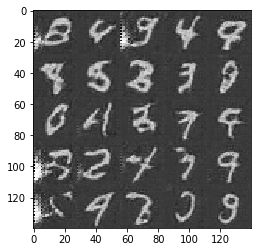

epoch 1, steps 919, d_loss=0.45130985975265503, g_loss=1.9022860527038574
epoch 1, steps 939, d_loss=1.0426863431930542, g_loss=1.0692808628082275
epoch 1, steps 959, d_loss=0.5185648798942566, g_loss=2.1159508228302
epoch 1, steps 979, d_loss=0.3962770998477936, g_loss=1.5985755920410156
epoch 1, steps 999, d_loss=0.7043008804321289, g_loss=2.035735845565796


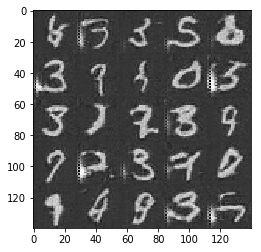

epoch 1, steps 1019, d_loss=0.3440694212913513, g_loss=2.612546920776367
epoch 1, steps 1039, d_loss=0.5718783140182495, g_loss=1.6620827913284302
epoch 1, steps 1059, d_loss=0.6788042783737183, g_loss=1.4057081937789917
epoch 1, steps 1079, d_loss=0.3099062740802765, g_loss=2.195340156555176
epoch 1, steps 1099, d_loss=0.3651016652584076, g_loss=1.7675378322601318


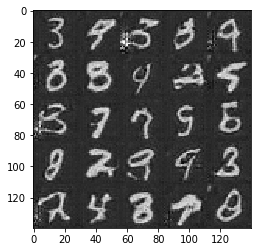

epoch 1, steps 1119, d_loss=0.30249980092048645, g_loss=2.239476442337036
epoch 1, steps 1139, d_loss=0.18071585893630981, g_loss=2.5325052738189697
epoch 1, steps 1159, d_loss=0.4087885320186615, g_loss=1.945332646369934
epoch 1, steps 1179, d_loss=0.4922748804092407, g_loss=1.7220158576965332
epoch 1, steps 1199, d_loss=0.3183099031448364, g_loss=2.9890947341918945


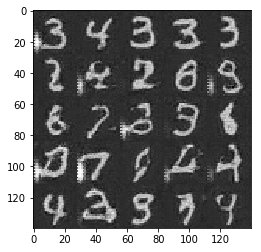

epoch 1, steps 1219, d_loss=1.036405324935913, g_loss=2.762239933013916
epoch 1, steps 1239, d_loss=0.779869019985199, g_loss=1.3044523000717163
epoch 1, steps 1259, d_loss=0.5139211416244507, g_loss=2.1457467079162598
epoch 1, steps 1279, d_loss=0.3060387372970581, g_loss=2.927945852279663
epoch 1, steps 1299, d_loss=0.40219467878341675, g_loss=2.9620578289031982


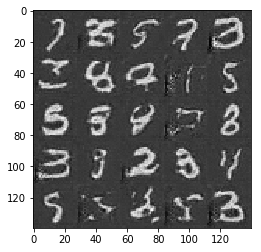

epoch 1, steps 1319, d_loss=0.19083420932292938, g_loss=3.187596559524536
epoch 1, steps 1339, d_loss=0.5569218397140503, g_loss=1.5240724086761475
epoch 1, steps 1359, d_loss=0.2959136962890625, g_loss=3.051103115081787
epoch 1, steps 1379, d_loss=0.5152220726013184, g_loss=1.3718444108963013
epoch 1, steps 1399, d_loss=0.47065067291259766, g_loss=2.080038070678711


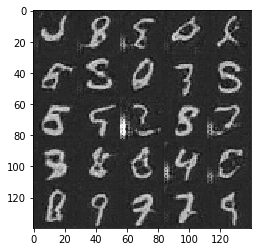

epoch 1, steps 1419, d_loss=0.8956236243247986, g_loss=1.7575417757034302
epoch 1, steps 1439, d_loss=0.7542939186096191, g_loss=1.479051113128662
epoch 1, steps 1459, d_loss=1.1166915893554688, g_loss=0.9155858159065247
epoch 1, steps 1479, d_loss=0.2761152386665344, g_loss=2.7064385414123535
epoch 1, steps 1499, d_loss=0.8235476613044739, g_loss=1.3488041162490845


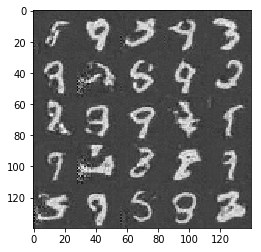

epoch 1, steps 1519, d_loss=0.40915969014167786, g_loss=2.417799472808838
epoch 1, steps 1539, d_loss=0.5795469880104065, g_loss=1.464555025100708
epoch 1, steps 1559, d_loss=0.802182137966156, g_loss=1.2145625352859497
epoch 1, steps 1579, d_loss=1.04242742061615, g_loss=0.9141541123390198
epoch 1, steps 1599, d_loss=0.41326475143432617, g_loss=1.6550676822662354


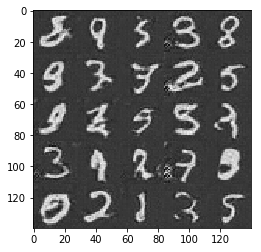

epoch 1, steps 1619, d_loss=0.4457414150238037, g_loss=2.4548654556274414
epoch 1, steps 1639, d_loss=0.39335232973098755, g_loss=2.566358804702759
epoch 1, steps 1659, d_loss=0.4905857741832733, g_loss=1.5464961528778076
epoch 1, steps 1679, d_loss=1.0210425853729248, g_loss=3.292268753051758
epoch 1, steps 1699, d_loss=0.6812497973442078, g_loss=2.4056410789489746


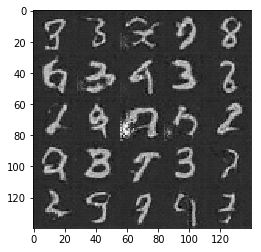

epoch 1, steps 1719, d_loss=0.729544997215271, g_loss=3.3391647338867188
epoch 1, steps 1739, d_loss=0.610083818435669, g_loss=1.80148184299469
epoch 1, steps 1759, d_loss=0.4286365807056427, g_loss=3.287149429321289
epoch 1, steps 1779, d_loss=0.8241865634918213, g_loss=1.3059635162353516
epoch 1, steps 1799, d_loss=1.1908777952194214, g_loss=0.8336077332496643


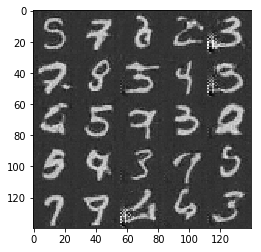

epoch 1, steps 1819, d_loss=1.0071866512298584, g_loss=3.7266225814819336
epoch 1, steps 1839, d_loss=1.0835926532745361, g_loss=4.175938606262207
epoch 1, steps 1859, d_loss=0.5826734304428101, g_loss=2.7455782890319824


In [63]:
batch_size = 32
z_dim = 100
learning_rate = 5e-4   # 1e-4, 1e-4, 1e-4, 2e-4, 5e-5, 1e-4, 2e-4, 1e-4, 5e-5, 1e-4
beta1 = 0.5            # 0.5, 0.3, 0.4, 0.5, 0.5, 0.5, 0.9, 0.9, 0.9, 0.9
                       # v, x, maybe, x, ?, maybe, x, x, x, x
                       # a2, a1, a1, ...


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch 0, steps 19, d_loss=0.30479559302330017, g_loss=4.971263885498047
epoch 0, steps 39, d_loss=0.6589098572731018, g_loss=15.687665939331055
epoch 0, steps 59, d_loss=0.1072704866528511, g_loss=11.927127838134766
epoch 0, steps 79, d_loss=0.2584438920021057, g_loss=3.562110424041748
epoch 0, steps 99, d_loss=0.2524338662624359, g_loss=3.195737600326538


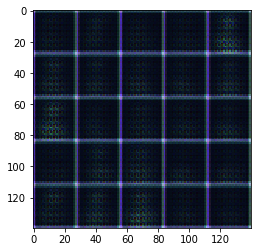

epoch 0, steps 119, d_loss=0.2861219048500061, g_loss=2.8761935234069824
epoch 0, steps 139, d_loss=0.4689862132072449, g_loss=2.1844019889831543
epoch 0, steps 159, d_loss=0.5630021095275879, g_loss=1.0925250053405762
epoch 0, steps 179, d_loss=0.6578671932220459, g_loss=1.3743137121200562
epoch 0, steps 199, d_loss=1.2294950485229492, g_loss=0.4658328890800476


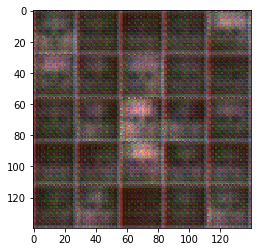

epoch 0, steps 219, d_loss=0.33654868602752686, g_loss=2.46299409866333
epoch 0, steps 239, d_loss=1.3729133605957031, g_loss=2.4099981784820557
epoch 0, steps 259, d_loss=2.2413570880889893, g_loss=5.181358337402344
epoch 0, steps 279, d_loss=0.2039528489112854, g_loss=4.787935733795166
epoch 0, steps 299, d_loss=0.45203712582588196, g_loss=3.7198400497436523


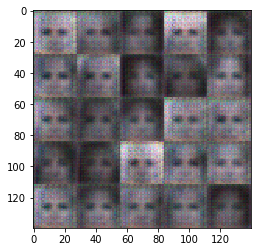

epoch 0, steps 319, d_loss=1.1149370670318604, g_loss=1.004822850227356
epoch 0, steps 339, d_loss=0.3783324062824249, g_loss=2.1658871173858643
epoch 0, steps 359, d_loss=0.7553282976150513, g_loss=1.6441230773925781
epoch 0, steps 379, d_loss=0.8336567282676697, g_loss=1.0902540683746338
epoch 0, steps 399, d_loss=0.30892258882522583, g_loss=3.986236572265625


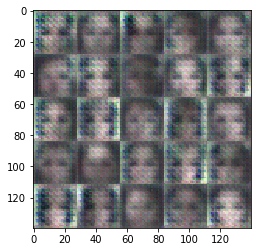

epoch 0, steps 419, d_loss=0.2983139455318451, g_loss=3.7537715435028076
epoch 0, steps 439, d_loss=0.8567468523979187, g_loss=1.0120538473129272
epoch 0, steps 459, d_loss=0.8328390717506409, g_loss=1.308536410331726
epoch 0, steps 479, d_loss=0.6132797002792358, g_loss=1.6924500465393066
epoch 0, steps 499, d_loss=0.3555528521537781, g_loss=1.748827338218689


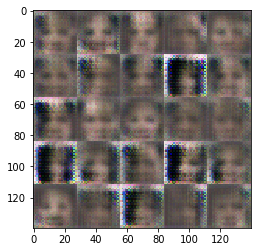

epoch 0, steps 519, d_loss=0.1984730362892151, g_loss=3.0544073581695557
epoch 0, steps 539, d_loss=0.3639698028564453, g_loss=3.323745012283325
epoch 0, steps 559, d_loss=0.1604137420654297, g_loss=3.5073304176330566
epoch 0, steps 579, d_loss=0.6685240268707275, g_loss=4.00351095199585
epoch 0, steps 599, d_loss=0.7242505550384521, g_loss=1.2457269430160522


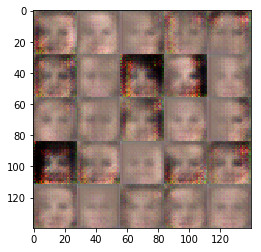

epoch 0, steps 619, d_loss=1.375514030456543, g_loss=0.4421587884426117
epoch 0, steps 639, d_loss=0.2922212779521942, g_loss=3.122732162475586
epoch 0, steps 659, d_loss=0.4836331903934479, g_loss=3.123391628265381
epoch 0, steps 679, d_loss=0.6077178716659546, g_loss=3.4195003509521484
epoch 0, steps 699, d_loss=0.40143823623657227, g_loss=2.7776331901550293


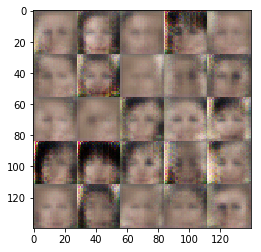

epoch 0, steps 719, d_loss=0.4373680651187897, g_loss=2.252164840698242
epoch 0, steps 739, d_loss=0.2768181562423706, g_loss=3.5929079055786133
epoch 0, steps 759, d_loss=0.6840153932571411, g_loss=1.2165926694869995
epoch 0, steps 779, d_loss=0.41541945934295654, g_loss=3.2339634895324707
epoch 0, steps 799, d_loss=0.6340019702911377, g_loss=2.247847557067871


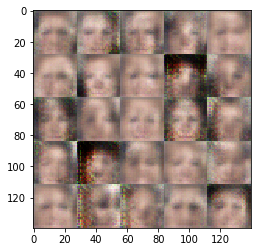

epoch 0, steps 819, d_loss=0.9395583868026733, g_loss=0.9340105056762695
epoch 0, steps 839, d_loss=0.49776893854141235, g_loss=3.1455559730529785
epoch 0, steps 859, d_loss=0.6319282054901123, g_loss=1.4420793056488037
epoch 0, steps 879, d_loss=0.7203285098075867, g_loss=2.710146903991699
epoch 0, steps 899, d_loss=0.6616188287734985, g_loss=2.396991014480591


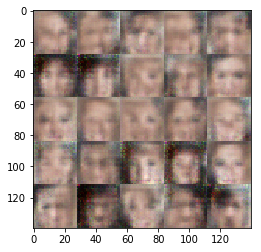

epoch 0, steps 919, d_loss=1.0934169292449951, g_loss=4.354005813598633
epoch 0, steps 939, d_loss=0.7342567443847656, g_loss=1.344948410987854
epoch 0, steps 959, d_loss=0.8458530902862549, g_loss=1.2976715564727783
epoch 0, steps 979, d_loss=0.7536531686782837, g_loss=1.2473070621490479
epoch 0, steps 999, d_loss=1.1192097663879395, g_loss=2.3044703006744385


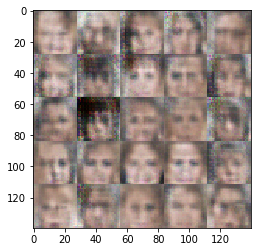

epoch 0, steps 1019, d_loss=0.5227237939834595, g_loss=2.7818679809570312
epoch 0, steps 1039, d_loss=0.7354175448417664, g_loss=1.118288278579712
epoch 0, steps 1059, d_loss=0.5843782424926758, g_loss=4.616376876831055
epoch 0, steps 1079, d_loss=0.6734006404876709, g_loss=3.6986641883850098
epoch 0, steps 1099, d_loss=0.4725411534309387, g_loss=2.6975765228271484


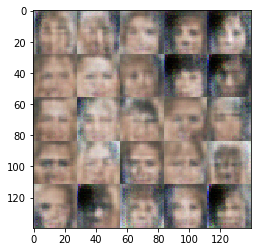

epoch 0, steps 1119, d_loss=0.7628802061080933, g_loss=2.0515449047088623
epoch 0, steps 1139, d_loss=0.5447512865066528, g_loss=1.4164068698883057
epoch 0, steps 1159, d_loss=0.7779611945152283, g_loss=4.300299644470215
epoch 0, steps 1179, d_loss=0.9214556217193604, g_loss=2.6543965339660645
epoch 0, steps 1199, d_loss=0.5016211867332458, g_loss=3.0301966667175293


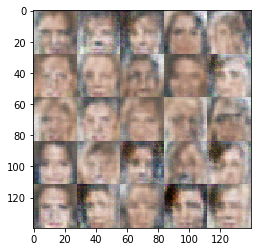

epoch 0, steps 1219, d_loss=0.9247297048568726, g_loss=1.48939847946167
epoch 0, steps 1239, d_loss=0.7840633988380432, g_loss=2.083160638809204
epoch 0, steps 1259, d_loss=0.5646235942840576, g_loss=3.086700439453125
epoch 0, steps 1279, d_loss=0.9827916622161865, g_loss=2.7043488025665283
epoch 0, steps 1299, d_loss=0.735146701335907, g_loss=1.8820536136627197


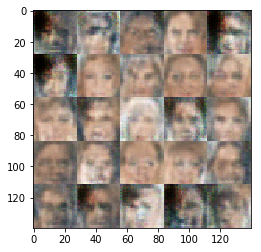

epoch 0, steps 1319, d_loss=0.7759424448013306, g_loss=1.735564947128296
epoch 0, steps 1339, d_loss=1.092097282409668, g_loss=1.0978150367736816
epoch 0, steps 1359, d_loss=0.8738889694213867, g_loss=1.3062411546707153
epoch 0, steps 1379, d_loss=0.7997265458106995, g_loss=1.6883667707443237
epoch 0, steps 1399, d_loss=1.1004633903503418, g_loss=1.9115397930145264


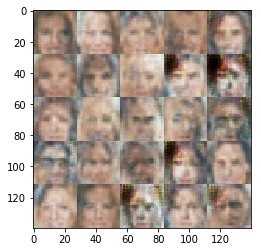

epoch 0, steps 1419, d_loss=0.8532232046127319, g_loss=1.9683523178100586
epoch 0, steps 1439, d_loss=0.8335613012313843, g_loss=1.9552931785583496
epoch 0, steps 1459, d_loss=0.8537358641624451, g_loss=2.1274261474609375
epoch 0, steps 1479, d_loss=0.616178572177887, g_loss=2.412349224090576
epoch 0, steps 1499, d_loss=0.9179092049598694, g_loss=1.848958969116211


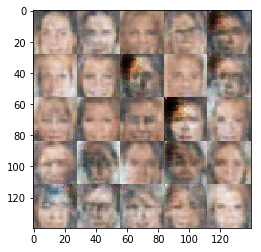

epoch 0, steps 1519, d_loss=0.5662268400192261, g_loss=2.9320881366729736
epoch 0, steps 1539, d_loss=0.9110406637191772, g_loss=1.7598869800567627
epoch 0, steps 1559, d_loss=0.7103970050811768, g_loss=2.2965328693389893
epoch 0, steps 1579, d_loss=0.6127039194107056, g_loss=3.1814255714416504
epoch 0, steps 1599, d_loss=0.9182924628257751, g_loss=1.7357470989227295


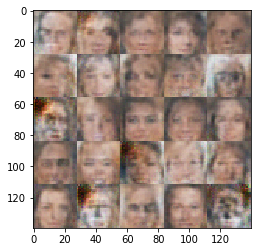

epoch 0, steps 1619, d_loss=0.9714824557304382, g_loss=1.2475963830947876
epoch 0, steps 1639, d_loss=0.8417156934738159, g_loss=2.3412933349609375
epoch 0, steps 1659, d_loss=1.184203028678894, g_loss=4.794247150421143
epoch 0, steps 1679, d_loss=0.6910356283187866, g_loss=1.7660655975341797
epoch 0, steps 1699, d_loss=1.242451786994934, g_loss=1.142356038093567


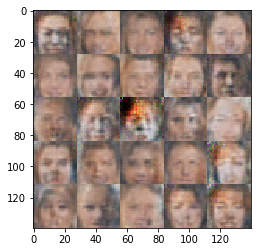

epoch 0, steps 1719, d_loss=0.8889635801315308, g_loss=1.8984565734863281
epoch 0, steps 1739, d_loss=0.7461425065994263, g_loss=1.641924500465393
epoch 0, steps 1759, d_loss=1.0041950941085815, g_loss=1.1018662452697754
epoch 0, steps 1779, d_loss=1.0681674480438232, g_loss=2.149040699005127
epoch 0, steps 1799, d_loss=0.9319944977760315, g_loss=1.4622328281402588


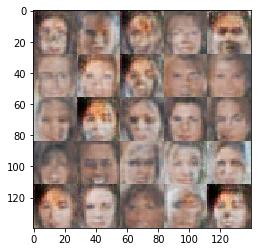

epoch 0, steps 1819, d_loss=0.9124581813812256, g_loss=2.220864772796631
epoch 0, steps 1839, d_loss=0.910983145236969, g_loss=4.070053577423096
epoch 0, steps 1859, d_loss=0.629591166973114, g_loss=2.977613925933838
epoch 0, steps 1879, d_loss=0.9056419134140015, g_loss=3.702087163925171
epoch 0, steps 1899, d_loss=0.6479856967926025, g_loss=2.250612258911133


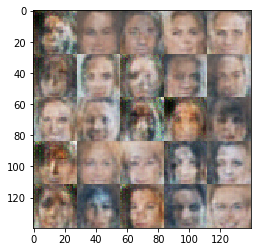

epoch 0, steps 1919, d_loss=0.9788917303085327, g_loss=1.5982905626296997
epoch 0, steps 1939, d_loss=0.8316565752029419, g_loss=2.515122890472412
epoch 0, steps 1959, d_loss=0.6891689300537109, g_loss=2.571819305419922
epoch 0, steps 1979, d_loss=0.8385676145553589, g_loss=1.1826645135879517
epoch 0, steps 1999, d_loss=0.7537978887557983, g_loss=1.5226919651031494


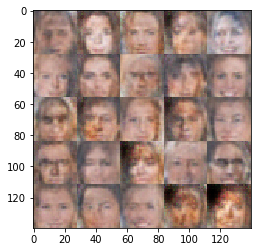

epoch 0, steps 2019, d_loss=0.7842488288879395, g_loss=1.5057814121246338
epoch 0, steps 2039, d_loss=1.1015067100524902, g_loss=3.3639841079711914
epoch 0, steps 2059, d_loss=0.7521971464157104, g_loss=1.4899591207504272
epoch 0, steps 2079, d_loss=0.6583911180496216, g_loss=2.052931308746338
epoch 0, steps 2099, d_loss=0.7852659225463867, g_loss=2.1184067726135254


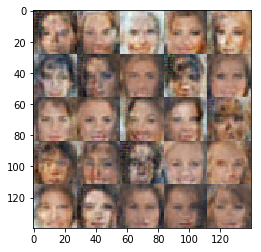

epoch 0, steps 2119, d_loss=0.9067322015762329, g_loss=1.110041856765747
epoch 0, steps 2139, d_loss=0.8449755907058716, g_loss=1.8098481893539429
epoch 0, steps 2159, d_loss=0.8317270278930664, g_loss=1.4881082773208618
epoch 0, steps 2179, d_loss=0.33902859687805176, g_loss=4.4908671379089355
epoch 0, steps 2199, d_loss=1.27401602268219, g_loss=0.7642329931259155


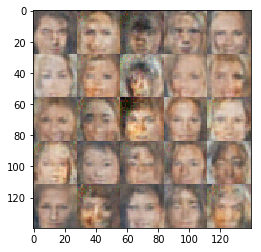

epoch 0, steps 2219, d_loss=0.8173320293426514, g_loss=1.4361680746078491
epoch 0, steps 2239, d_loss=0.7462165355682373, g_loss=1.6910747289657593
epoch 0, steps 2259, d_loss=0.8517236709594727, g_loss=1.2449564933776855
epoch 0, steps 2279, d_loss=0.6725733280181885, g_loss=2.284247398376465
epoch 0, steps 2299, d_loss=0.746023952960968, g_loss=1.3354177474975586


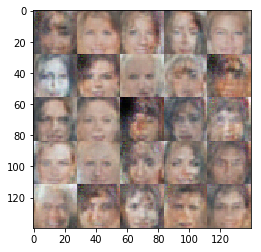

epoch 0, steps 2319, d_loss=0.9193950891494751, g_loss=1.1439855098724365
epoch 0, steps 2339, d_loss=0.685344934463501, g_loss=1.6492576599121094
epoch 0, steps 2359, d_loss=0.8787006735801697, g_loss=2.1073453426361084
epoch 0, steps 2379, d_loss=1.055411458015442, g_loss=1.0305895805358887
epoch 0, steps 2399, d_loss=0.7342007160186768, g_loss=2.6817100048065186


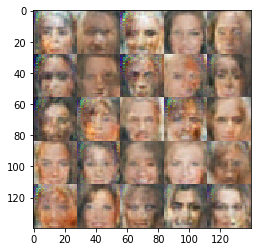

epoch 0, steps 2419, d_loss=0.7887153029441833, g_loss=1.805484414100647
epoch 0, steps 2439, d_loss=0.7253233194351196, g_loss=4.092988014221191
epoch 0, steps 2459, d_loss=0.6859287619590759, g_loss=2.179241895675659
epoch 0, steps 2479, d_loss=0.856122612953186, g_loss=1.3250948190689087
epoch 0, steps 2499, d_loss=1.0582997798919678, g_loss=1.8389179706573486


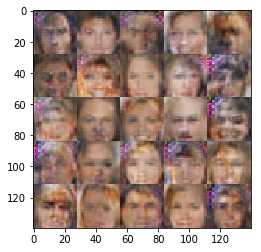

epoch 0, steps 2519, d_loss=0.9596381187438965, g_loss=2.620973587036133
epoch 0, steps 2539, d_loss=0.741340696811676, g_loss=2.436098098754883
epoch 0, steps 2559, d_loss=0.7447795867919922, g_loss=1.7909002304077148
epoch 0, steps 2579, d_loss=0.9160797595977783, g_loss=1.262643814086914
epoch 0, steps 2599, d_loss=0.7702312469482422, g_loss=1.3433253765106201


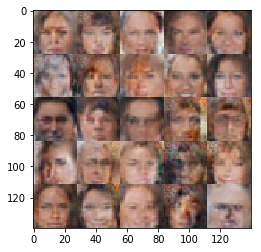

epoch 0, steps 2619, d_loss=1.0749579668045044, g_loss=1.4316246509552002
epoch 0, steps 2639, d_loss=0.7979726791381836, g_loss=1.332435131072998
epoch 0, steps 2659, d_loss=0.7851485013961792, g_loss=1.6729309558868408
epoch 0, steps 2679, d_loss=0.7056295275688171, g_loss=2.069204807281494
epoch 0, steps 2699, d_loss=0.9157109260559082, g_loss=1.3248987197875977


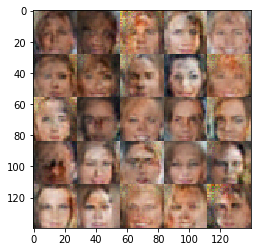

epoch 0, steps 2719, d_loss=0.9534121751785278, g_loss=1.1099960803985596
epoch 0, steps 2739, d_loss=1.0272587537765503, g_loss=1.0203077793121338
epoch 0, steps 2759, d_loss=0.9349310398101807, g_loss=1.4930737018585205
epoch 0, steps 2779, d_loss=0.7539689540863037, g_loss=2.466966390609741
epoch 0, steps 2799, d_loss=0.965854823589325, g_loss=1.5320924520492554


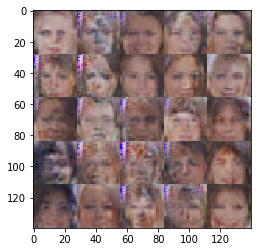

epoch 0, steps 2819, d_loss=0.7574164271354675, g_loss=1.5141476392745972
epoch 0, steps 2839, d_loss=0.9799320101737976, g_loss=1.533839225769043
epoch 0, steps 2859, d_loss=0.8809819221496582, g_loss=0.9907686710357666
epoch 0, steps 2879, d_loss=0.9258822202682495, g_loss=1.0826947689056396
epoch 0, steps 2899, d_loss=1.0605558156967163, g_loss=2.306015729904175


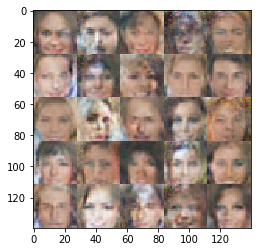

epoch 0, steps 2919, d_loss=0.6325433254241943, g_loss=2.138481616973877
epoch 0, steps 2939, d_loss=0.6803430318832397, g_loss=1.4546723365783691
epoch 0, steps 2959, d_loss=0.7984750866889954, g_loss=1.4938015937805176
epoch 0, steps 2979, d_loss=0.7735337018966675, g_loss=1.36161208152771
epoch 0, steps 2999, d_loss=1.0270365476608276, g_loss=0.8864339590072632


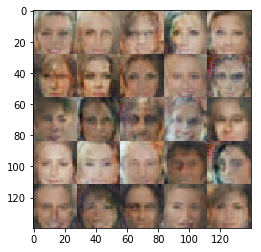

epoch 0, steps 3019, d_loss=0.7448469996452332, g_loss=1.493303656578064
epoch 0, steps 3039, d_loss=0.9923555850982666, g_loss=2.214824676513672
epoch 0, steps 3059, d_loss=0.6665589809417725, g_loss=1.7331682443618774
epoch 0, steps 3079, d_loss=1.043539047241211, g_loss=1.6965105533599854
epoch 0, steps 3099, d_loss=0.8112397193908691, g_loss=2.655646800994873


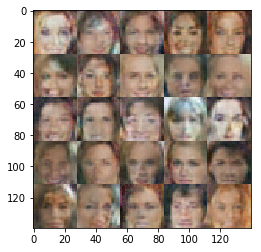

epoch 0, steps 3119, d_loss=0.7505670189857483, g_loss=2.7210841178894043
epoch 0, steps 3139, d_loss=0.7838138341903687, g_loss=1.385208249092102
epoch 0, steps 3159, d_loss=0.8366091251373291, g_loss=0.8919720649719238
epoch 0, steps 3179, d_loss=0.841018557548523, g_loss=1.2234294414520264
epoch 0, steps 3199, d_loss=0.9462195634841919, g_loss=1.3366575241088867


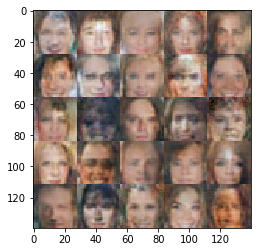

epoch 0, steps 3219, d_loss=0.7523634433746338, g_loss=1.278367280960083
epoch 0, steps 3239, d_loss=0.8319369554519653, g_loss=1.025691270828247
epoch 0, steps 3259, d_loss=0.8646107316017151, g_loss=1.0643420219421387
epoch 0, steps 3279, d_loss=0.703182578086853, g_loss=1.3388032913208008
epoch 0, steps 3299, d_loss=0.7257816791534424, g_loss=1.2440121173858643


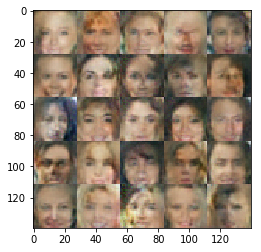

epoch 0, steps 3319, d_loss=0.9023893475532532, g_loss=1.705061674118042
epoch 0, steps 3339, d_loss=0.760406494140625, g_loss=1.1089407205581665
epoch 0, steps 3359, d_loss=0.9146690964698792, g_loss=2.4949522018432617
epoch 0, steps 3379, d_loss=0.7541109919548035, g_loss=1.280198335647583
epoch 0, steps 3399, d_loss=0.811528205871582, g_loss=1.064306616783142


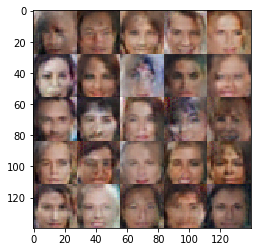

epoch 0, steps 3419, d_loss=0.7354975938796997, g_loss=1.492816686630249
epoch 0, steps 3439, d_loss=1.1643130779266357, g_loss=0.5519358515739441
epoch 0, steps 3459, d_loss=0.9066898226737976, g_loss=1.481642723083496
epoch 0, steps 3479, d_loss=0.8087911605834961, g_loss=1.157867431640625
epoch 0, steps 3499, d_loss=0.8507145047187805, g_loss=1.3686552047729492


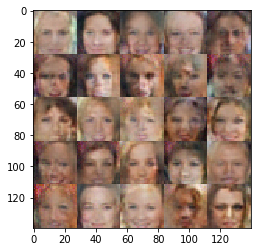

epoch 0, steps 3519, d_loss=0.9858990907669067, g_loss=2.3779139518737793
epoch 0, steps 3539, d_loss=0.8036937713623047, g_loss=1.504370927810669
epoch 0, steps 3559, d_loss=0.8761496543884277, g_loss=1.8473845720291138
epoch 0, steps 3579, d_loss=0.7121237516403198, g_loss=1.6720659732818604
epoch 0, steps 3599, d_loss=1.0251328945159912, g_loss=2.6886372566223145


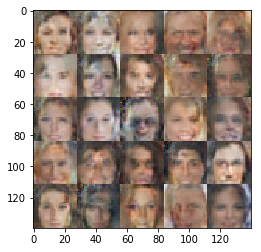

epoch 0, steps 3619, d_loss=0.9503008127212524, g_loss=0.8638471961021423
epoch 0, steps 3639, d_loss=0.9821557998657227, g_loss=1.7989097833633423
epoch 0, steps 3659, d_loss=0.7015682458877563, g_loss=1.100411057472229
epoch 0, steps 3679, d_loss=0.7843496799468994, g_loss=1.6110140085220337
epoch 0, steps 3699, d_loss=0.8393866419792175, g_loss=1.1296789646148682


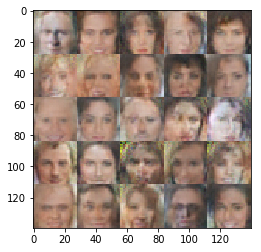

epoch 0, steps 3719, d_loss=0.9032220840454102, g_loss=1.0560860633850098
epoch 0, steps 3739, d_loss=0.8349334001541138, g_loss=1.8737573623657227
epoch 0, steps 3759, d_loss=0.9443427324295044, g_loss=1.4018492698669434
epoch 0, steps 3779, d_loss=0.8525808453559875, g_loss=1.096154808998108
epoch 0, steps 3799, d_loss=1.558966875076294, g_loss=0.5246721506118774


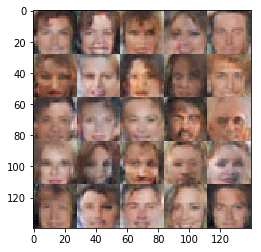

epoch 0, steps 3819, d_loss=0.7131829857826233, g_loss=1.287832260131836
epoch 0, steps 3839, d_loss=1.2227991819381714, g_loss=2.507453203201294
epoch 0, steps 3859, d_loss=0.8227059841156006, g_loss=1.6728278398513794
epoch 0, steps 3879, d_loss=0.646157443523407, g_loss=1.9063605070114136
epoch 0, steps 3899, d_loss=0.864402174949646, g_loss=1.0391709804534912


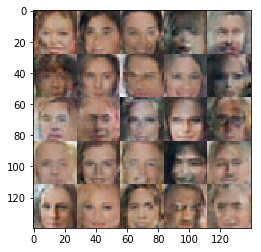

epoch 0, steps 3919, d_loss=1.0525922775268555, g_loss=1.2192095518112183
epoch 0, steps 3939, d_loss=0.94358229637146, g_loss=0.9372124671936035
epoch 0, steps 3959, d_loss=0.8280454277992249, g_loss=1.0728119611740112
epoch 0, steps 3979, d_loss=0.7767118215560913, g_loss=1.3836684226989746
epoch 0, steps 3999, d_loss=0.882671594619751, g_loss=1.005293369293213


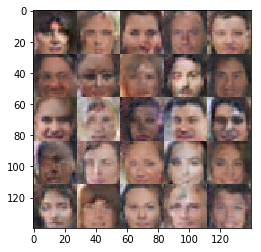

epoch 0, steps 4019, d_loss=0.8497320413589478, g_loss=1.020531415939331
epoch 0, steps 4039, d_loss=0.8434141278266907, g_loss=1.172075629234314
epoch 0, steps 4059, d_loss=0.7731208205223083, g_loss=1.6031161546707153
epoch 0, steps 4079, d_loss=0.8983402252197266, g_loss=1.9703195095062256
epoch 0, steps 4099, d_loss=0.9236752986907959, g_loss=0.7563211917877197


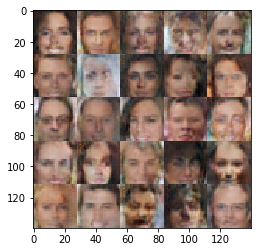

epoch 0, steps 4119, d_loss=0.7902557849884033, g_loss=1.6064729690551758
epoch 0, steps 4139, d_loss=0.8499300479888916, g_loss=2.1354198455810547
epoch 0, steps 4159, d_loss=0.5967892408370972, g_loss=1.4192439317703247
epoch 0, steps 4179, d_loss=1.0595877170562744, g_loss=2.169257640838623
epoch 0, steps 4199, d_loss=1.0684925317764282, g_loss=0.8167885541915894


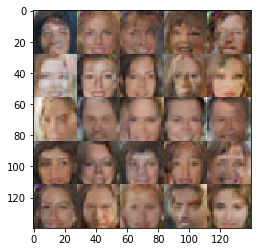

epoch 0, steps 4219, d_loss=0.8798295259475708, g_loss=0.9682788848876953
epoch 0, steps 4239, d_loss=0.8128979206085205, g_loss=1.0604537725448608
epoch 0, steps 4259, d_loss=0.6723325252532959, g_loss=1.6249322891235352
epoch 0, steps 4279, d_loss=0.7446551322937012, g_loss=1.6671746969223022
epoch 0, steps 4299, d_loss=0.839445948600769, g_loss=0.8652330636978149


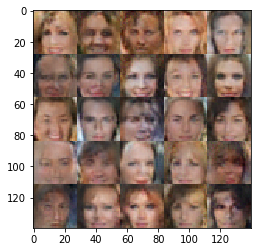

epoch 0, steps 4319, d_loss=0.8853106498718262, g_loss=1.129347801208496
epoch 0, steps 4339, d_loss=0.7006841897964478, g_loss=1.5223515033721924
epoch 0, steps 4359, d_loss=0.8753879070281982, g_loss=2.436718463897705
epoch 0, steps 4379, d_loss=0.9955283403396606, g_loss=0.9450410008430481
epoch 0, steps 4399, d_loss=0.7455008029937744, g_loss=1.3278412818908691


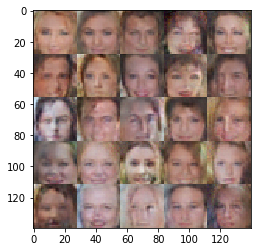

epoch 0, steps 4419, d_loss=0.850679874420166, g_loss=1.3261089324951172
epoch 0, steps 4439, d_loss=0.7727911472320557, g_loss=1.2732796669006348
epoch 0, steps 4459, d_loss=1.144557237625122, g_loss=0.6794604063034058
epoch 0, steps 4479, d_loss=0.8927914500236511, g_loss=1.2097914218902588
epoch 0, steps 4499, d_loss=0.8186136484146118, g_loss=1.4951419830322266


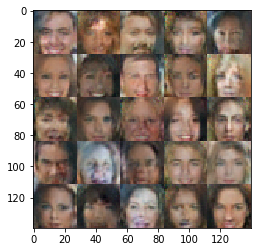

epoch 0, steps 4519, d_loss=1.0456972122192383, g_loss=0.8426239490509033
epoch 0, steps 4539, d_loss=0.7765318155288696, g_loss=1.0112650394439697
epoch 0, steps 4559, d_loss=1.6067018508911133, g_loss=3.3492772579193115
epoch 0, steps 4579, d_loss=0.7624537348747253, g_loss=1.17084538936615
epoch 0, steps 4599, d_loss=0.6996703147888184, g_loss=1.6115331649780273


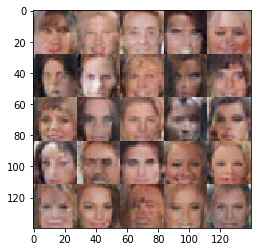

epoch 0, steps 4619, d_loss=0.7390429973602295, g_loss=1.168867588043213
epoch 0, steps 4639, d_loss=0.9317829608917236, g_loss=1.3757197856903076
epoch 0, steps 4659, d_loss=0.7746874094009399, g_loss=1.7258875370025635
epoch 0, steps 4679, d_loss=0.7901321053504944, g_loss=1.916773796081543
epoch 0, steps 4699, d_loss=1.2794533967971802, g_loss=0.599030077457428


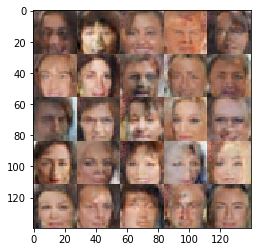

epoch 0, steps 4719, d_loss=0.8658202290534973, g_loss=1.4540424346923828
epoch 0, steps 4739, d_loss=0.7354789972305298, g_loss=1.0257725715637207
epoch 0, steps 4759, d_loss=0.8839621543884277, g_loss=1.3777275085449219
epoch 0, steps 4779, d_loss=0.9098707437515259, g_loss=0.977203905582428
epoch 0, steps 4799, d_loss=0.9903995394706726, g_loss=0.8556041717529297


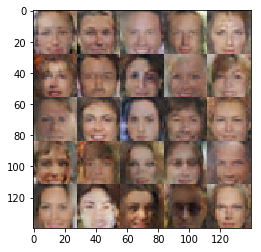

epoch 0, steps 4819, d_loss=0.7782406210899353, g_loss=1.2686405181884766
epoch 0, steps 4839, d_loss=0.7491722106933594, g_loss=1.7707507610321045
epoch 0, steps 4859, d_loss=0.8842904567718506, g_loss=1.1382670402526855
epoch 0, steps 4879, d_loss=0.8318319320678711, g_loss=2.225154399871826
epoch 0, steps 4899, d_loss=0.7222986817359924, g_loss=1.5428547859191895


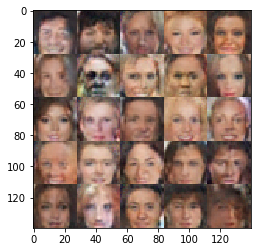

epoch 0, steps 4919, d_loss=1.061232328414917, g_loss=0.777604877948761
epoch 0, steps 4939, d_loss=0.8024146556854248, g_loss=1.441828727722168
epoch 0, steps 4959, d_loss=0.8337023258209229, g_loss=0.972821831703186
epoch 0, steps 4979, d_loss=0.9548889398574829, g_loss=0.8700653910636902
epoch 0, steps 4999, d_loss=0.8978629112243652, g_loss=1.0710842609405518


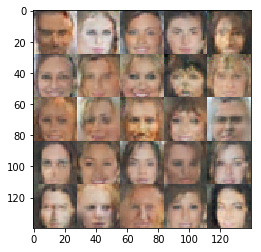

epoch 0, steps 5019, d_loss=0.6810159087181091, g_loss=1.2643928527832031
epoch 0, steps 5039, d_loss=0.8000251650810242, g_loss=1.730076789855957
epoch 0, steps 5059, d_loss=0.8915743827819824, g_loss=1.2194123268127441
epoch 0, steps 5079, d_loss=1.4115937948226929, g_loss=0.485227108001709
epoch 0, steps 5099, d_loss=0.8695721626281738, g_loss=1.199510931968689


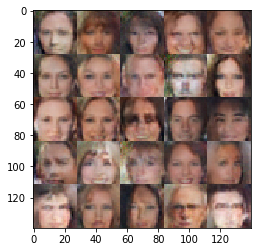

epoch 0, steps 5119, d_loss=0.9388389587402344, g_loss=0.898242712020874
epoch 0, steps 5139, d_loss=0.8609133958816528, g_loss=0.8450796008110046
epoch 0, steps 5159, d_loss=0.9266451001167297, g_loss=1.1287660598754883
epoch 0, steps 5179, d_loss=0.5645896792411804, g_loss=1.722620964050293
epoch 0, steps 5199, d_loss=1.2202045917510986, g_loss=0.5967272520065308


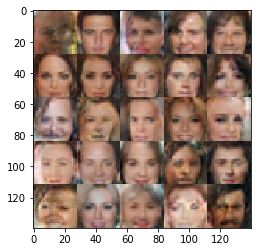

epoch 0, steps 5219, d_loss=0.8741893768310547, g_loss=1.0465786457061768
epoch 0, steps 5239, d_loss=0.9904216527938843, g_loss=0.9875491261482239
epoch 0, steps 5259, d_loss=0.6453984975814819, g_loss=1.3626909255981445
epoch 0, steps 5279, d_loss=0.7432143688201904, g_loss=1.1760222911834717
epoch 0, steps 5299, d_loss=0.8003175854682922, g_loss=0.9611809253692627


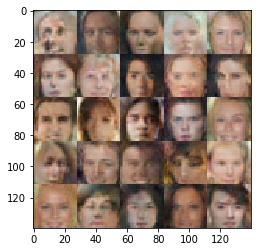

epoch 0, steps 5319, d_loss=0.7589302062988281, g_loss=1.119565486907959
epoch 0, steps 5339, d_loss=0.9095842242240906, g_loss=1.227494239807129
epoch 0, steps 5359, d_loss=0.9846553802490234, g_loss=0.8930491209030151
epoch 0, steps 5379, d_loss=0.8613446950912476, g_loss=0.8991402387619019
epoch 0, steps 5399, d_loss=0.9170957803726196, g_loss=1.1565543413162231


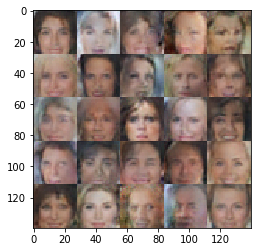

epoch 0, steps 5419, d_loss=0.8346911668777466, g_loss=2.094058036804199
epoch 0, steps 5439, d_loss=0.9255929589271545, g_loss=1.2346937656402588
epoch 0, steps 5459, d_loss=0.8594256639480591, g_loss=0.9714468717575073
epoch 0, steps 5479, d_loss=0.8566842675209045, g_loss=1.3179657459259033
epoch 0, steps 5499, d_loss=0.9111717939376831, g_loss=1.375342607498169


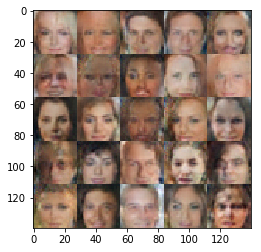

epoch 0, steps 5519, d_loss=0.8997198343276978, g_loss=0.9345492720603943
epoch 0, steps 5539, d_loss=0.8479296565055847, g_loss=1.0039504766464233
epoch 0, steps 5559, d_loss=0.6929518580436707, g_loss=1.7626745700836182
epoch 0, steps 5579, d_loss=1.1523973941802979, g_loss=0.7239254713058472
epoch 0, steps 5599, d_loss=0.847771167755127, g_loss=1.278293251991272


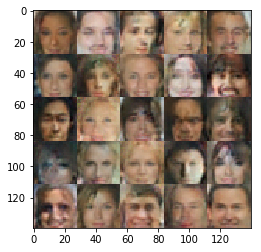

epoch 0, steps 5619, d_loss=0.7525041103363037, g_loss=1.2054638862609863
epoch 0, steps 5639, d_loss=0.9470481276512146, g_loss=0.9643840789794922
epoch 0, steps 5659, d_loss=0.8135879039764404, g_loss=1.392812967300415
epoch 0, steps 5679, d_loss=1.0896809101104736, g_loss=0.6279617547988892
epoch 0, steps 5699, d_loss=0.9629007577896118, g_loss=0.993696391582489


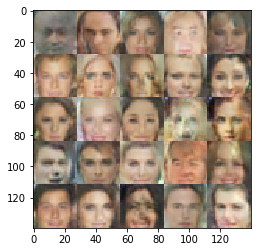

epoch 0, steps 5719, d_loss=0.9162964820861816, g_loss=1.0364148616790771
epoch 0, steps 5739, d_loss=0.7668131589889526, g_loss=1.0301504135131836
epoch 0, steps 5759, d_loss=0.6825469732284546, g_loss=1.2963039875030518
epoch 0, steps 5779, d_loss=0.9089280962944031, g_loss=1.169907569885254
epoch 0, steps 5799, d_loss=1.2355985641479492, g_loss=0.7090024948120117


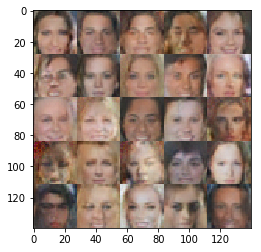

epoch 0, steps 5819, d_loss=0.7516322135925293, g_loss=1.2355985641479492
epoch 0, steps 5839, d_loss=1.2303787469863892, g_loss=0.7527503967285156
epoch 0, steps 5859, d_loss=1.0049433708190918, g_loss=0.9538074731826782
epoch 0, steps 5879, d_loss=0.7392261624336243, g_loss=0.9643791913986206
epoch 0, steps 5899, d_loss=0.8046817779541016, g_loss=1.317178726196289


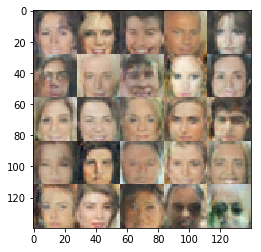

epoch 0, steps 5919, d_loss=0.9484363198280334, g_loss=0.9902592897415161
epoch 0, steps 5939, d_loss=0.9511970281600952, g_loss=1.110987663269043
epoch 0, steps 5959, d_loss=0.949522852897644, g_loss=1.1681644916534424
epoch 0, steps 5979, d_loss=0.8129003047943115, g_loss=1.014312982559204
epoch 0, steps 5999, d_loss=1.1785900592803955, g_loss=0.7961747050285339


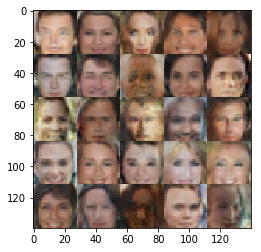

epoch 0, steps 6019, d_loss=0.9539881348609924, g_loss=1.4262466430664062
epoch 0, steps 6039, d_loss=1.0470900535583496, g_loss=0.9594082832336426
epoch 0, steps 6059, d_loss=0.7115625143051147, g_loss=1.522087812423706
epoch 0, steps 6079, d_loss=0.8545704483985901, g_loss=1.522118330001831
epoch 0, steps 6099, d_loss=0.9400126934051514, g_loss=0.8968157768249512


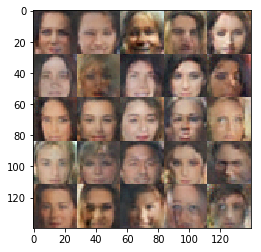

epoch 0, steps 6119, d_loss=1.049103856086731, g_loss=0.7867189645767212
epoch 0, steps 6139, d_loss=0.835094690322876, g_loss=1.194840669631958
epoch 0, steps 6159, d_loss=0.753707766532898, g_loss=1.319226861000061
epoch 0, steps 6179, d_loss=0.8177554607391357, g_loss=0.9758068919181824
epoch 0, steps 6199, d_loss=0.6985112428665161, g_loss=1.4534283876419067


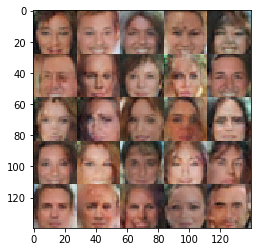

epoch 0, steps 6219, d_loss=0.7239822149276733, g_loss=0.9657922983169556
epoch 0, steps 6239, d_loss=1.0877187252044678, g_loss=0.7036733627319336
epoch 0, steps 6259, d_loss=0.9318374395370483, g_loss=0.9681851863861084
epoch 0, steps 6279, d_loss=1.3029831647872925, g_loss=0.7363804578781128
epoch 0, steps 6299, d_loss=0.7951377034187317, g_loss=1.0808885097503662


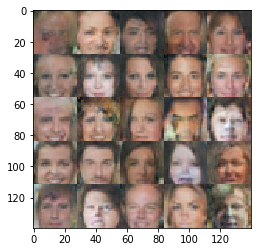

epoch 0, steps 6319, d_loss=1.0417684316635132, g_loss=1.1298524141311646


In [64]:
batch_size = 32
z_dim = 100
learning_rate = 2e-4
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.